In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from PIL import Image, ExifTags
import uuid
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from scipy.spatial import distance 
from sklearn.metrics import pairwise_distances
from numba import jit, prange
from concurrent.futures import ProcessPoolExecutor

from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise
import time
import sqlite3
import pickle

import torch
from torchvision import models, transforms

# Retrival Pipeline

In [2]:
def find_image_files(root_dir, extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')):
    '''
    Load all image paths and get the total number of images,
    we can't use tqdm here, because we have to determine the number of images first.
    '''
    image_files = []
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(extensions):
                image_files.append(os.path.join(subdir, file))
    return image_files

In [3]:
# Measurement functions

def image_rgb_calculation(image):
    # OpenCV uses BGR color space, we have to convert it to the RGB color space
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate the histogram
    hist = cv2.calcHist([rgb_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram so that histograms of different images (different sizes, resolutions) are comparable
    hist = cv2.normalize(hist, hist)
    hist = hist.flatten()
    return hist


def image_hsv_calculation(image):
    # OpenCV uses BGR color space, we have to convert it to the RGB color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate the histogram (bin-sizes = 8, values from 0-255)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    
    # Normalize the histogram so that histograms of different images (different sizes, resolutions) are comparable
    hist = cv2.normalize(hist, hist)
    hist = hist.flatten()
    return hist


def load_embedding_model():
    global model, preprocess
    # Load the efficientnet_v2_s model
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

    # Remove last layer (classificator), because we only need the features
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()

    # Define preprocessing transformations
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    
def model_embeddings_calculation(image):
    global model, preprocess
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    with torch.no_grad():
        features = model(input_batch)
    features = torch.flatten(features, 1)
    
    return features.numpy().flatten()

In [4]:
def extract_image_details(image_id, path, resize_size):
    try:
        image = cv2.imread(path)
        if image is not None:
            image = cv2.resize(image, resize_size)
            rgb_histogram = image_rgb_calculation(image)
            hsv_histogram = image_hsv_calculation(image)
            model_embedding = model_embeddings_calculation(image)
            
            ### several more informations ###
            
            # Convert to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Calculate average color and brightness
            avg_color = np.mean(image_rgb, axis=(0, 1)).tolist()
            avg_brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

            # Convert to HSV and calculate average HSV
            image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            avg_hsv = np.mean(image_hsv, axis=(0, 1)).tolist()

            # File details
            file_size = os.path.getsize(path)
            file_type = os.path.splitext(path)[1]

            with Image.open(path) as img:
                # Resolution and DPI
                resolution = img.size  # (width, height)
                dpi = img.info.get('dpi', (0, 0))
                
                # Extract metadata
                try:
                    exif_data = img._getexif()
                    metadata = {ExifTags.TAGS.get(k, k): v for k, v in exif_data.items()} if exif_data else {}
                except AttributeError:
                    metadata = {}
            
            
            #################################
            
            
            return {
                'ID': image_id,
                'Path': path,
                'RGB_Histogram': rgb_histogram,
                'HSV_Histogram': hsv_histogram,
                'Model_Embedding': model_embedding,
                'Average_Color': avg_color,
                'Brightness': avg_brightness,
                'Average_HSV': avg_hsv,
                'Resolution': resolution,
                'DPI': dpi,
                'File_Size': file_size,
                'File_Type': file_type,
                'Metadata': metadata
            }
        
        else:
            print(f"Image at path {path} is None.")
            return None
        
    except Exception as e:
        print(f"Failed processing {path}: {e}")
        return None

    
def load_checkpoint():
    if not os.path.exists('checkpoint.pkl'):
        return 0, [], [], [], [], []
    
    with open('checkpoint.pkl', 'rb') as f:
        batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data = pickle.load(f)
        print(f"Loaded checkpoint.\nStarting from path with ID: {batch_index + 1}")

    return batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data
    
    

def image_batch_generator(image_files, batch_size, resize_size, start_index = 0, show_progress=True):
    total_batches = (len(image_files) - start_index + batch_size - 1) // batch_size # - start_index to display remaining batches correctly
    progress_bar = tqdm(total=total_batches, desc="Processing images") if show_progress else None

    for index in range(start_index, len(image_files), batch_size):
        batch = image_files[index:index + batch_size]
        details_list = [extract_image_details(index + i + 1, path, resize_size) for i, path in enumerate(batch)]
        details_list = [features for features in details_list if features is not None]
        df = pd.DataFrame(details_list)
        yield df, index + batch_size
        if show_progress:
            progress_bar.update(1)

    if show_progress:
        progress_bar.close()



def main_load_images(batch_size, desired_size):
    # Load checkpoint
    start_index, paths, rgb_hists, hsv_hists, embeddings, other_data = load_checkpoint()

    image_paths = find_image_files(r"C:\Users\timsa\Desktop\Daten_Joschua\data\image_data\extra_collection\city")
    
    load_embedding_model()

    for df, batch_index in image_batch_generator(image_paths, batch_size, desired_size, start_index=start_index, show_progress=True):
        paths.extend(df[['ID', 'Path']].values.tolist())
        rgb_hists.extend(df[['ID', 'RGB_Histogram']].values.tolist())
        hsv_hists.extend(df[['ID', 'HSV_Histogram']].values.tolist())
        embeddings.extend(df[['ID', 'Model_Embedding']].values.tolist())
        other_data.extend(df.drop(columns=['Path', 'RGB_Histogram', 'HSV_Histogram', 'Model_Embedding']).values.tolist())

        # Save checkpoint, overrides old one and appends new data
        with open('checkpoint.pkl', 'wb') as f:
            pickle.dump((batch_index, paths, rgb_hists, hsv_hists, embeddings, other_data), f)
    

    # Save results
    df_paths = pd.DataFrame(paths, columns=["ID", "Path"])
    df_rgb = pd.DataFrame(rgb_hists, columns=["ID", "Histogram"])
    df_hsv = pd.DataFrame(hsv_hists, columns=["ID", "Histogram"])
    df_embeddings = pd.DataFrame(embeddings, columns=["ID", "Embedding"])
    df_other_data = pd.DataFrame(other_data, columns=["ID", "Average_Color",
                                                     "Brightness", "Average_HSV",
                                                     "Resolution","DPI",
                                                     "File_Size", "File_Type",
                                                     "Metadata"
                                                    ])

    df_paths.to_pickle('Path.pkl')
    df_rgb.to_pickle('RGB_Hist.pkl')
    df_hsv.to_pickle('HSV_Hist.pkl')
    df_embeddings.to_pickle('Embedding.pkl')
    df_other_data.to_pickle('Other_data.pkl')

    # Checkpoint can be removed after program was successful
    if os.path.exists('checkpoint.pkl'):
        os.remove('checkpoint.pkl')

In [5]:
%%time
# Execute
batch_size = 1000
desired_size = (224, 224)
main_load_images(batch_size, desired_size)

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
def create_database():
    # Check if the folder 'databases' does not exist / create it
    if not os.path.exists('database'):
        os.makedirs('database')

    conn = sqlite3.connect("database/bd_database.db")
    curs = conn.cursor()

    curs.execute("""CREATE TABLE IF NOT EXISTS image_paths 
                    (ID INTEGER PRIMARY KEY,
                    Path text);""")
    conn.commit()

In [45]:
def save_to_db(df, conn):
    curs = conn.cursor()
    for file_path in df['Path']:
        curs.execute('''INSERT OR IGNORE INTO image_paths (Path) VALUES (?);''', (file_path,))
    conn.commit()

In [46]:
create_database()

In [47]:
path_df = pd.read_pickle("Path.pkl")
connection = conn = sqlite3.connect("database/bd_database.db")
save_to_db(path_df, connection)

# Testing Similarities

In [16]:
def load_pickles():
    rgb_df = pd.read_pickle("RGB_Hist.pkl")
    hsv_df = pd.read_pickle("HSV_Hist.pkl")
    embedding_df = pd.read_pickle("Embedding.pkl")
    path_df = pd.read_pickle("Path.pkl")
    other_data_df = pd.read_pickle("Other_data.pkl")
    
    return rgb_df, hsv_df, embedding_df, path_df, other_data_df



def find_similar_ids(measurement, similarity, df_input, best_n):
    similarity_functions = {
        "euclidean_distance": "euclidean",
        "manhattan_distance": "cityblock",
        "cosine_similarity": "cosine"
    }
    
    histogram_columns = {
        "RGB": "RGB_Histogram",
        "HSV": "HSV_Histogram",
        "Embedding": "Model_Embedding"
    }
    
    dataframes = {
        "RGB": rgb_df,
        "HSV": hsv_df,
        "Embedding": embedding_df
    }
    
    # Create new input-df with the needed column
    df_input_selected = df_input[["ID", histogram_columns[measurement]]]
    
    # Select needed comparison-df
    target_df = dataframes[measurement]
    
    # Select comparison function
    similarity_function = similarity_functions[similarity]

    similarity_ids = calculate_mean_similarity(df_input_selected, target_df, similarity_function, best_n)
    return similarity_ids

In [6]:
# Plot images
def get_result_paths(curs, similarity_results):
    result_paths = []
    for image_id in similarity_results:
        curs.execute("""SELECT path
                        FROM image_paths
                        WHERE ID == (?);""", (image_id,))
        results = curs.fetchall()

        # If there are results save only the path (otherwise the output would be lists with tuples)
        if results:
            result_paths.append(results[0][0])
    return result_paths


def print_images(input_images, result_paths, input_images_number, similarities):
    # Subplots to plot input(s) and results
    fig, axes = plt.subplots(2, 5, figsize=(20, 5))

    # Input(s)
    for i in range(5):
        if i < input_images_number:
            image = Image.open(input_images[i])
            axes[0, i].imshow(image)
            axes[0, i].set_title(f"Input: {i+1}")
        axes[0, i].axis('off')

    # Results
    for i in range(5):
        if i < 5:
            image = Image.open(result_paths[i])
            axes[1, i].imshow(image)
            axes[1, i].set_title(f"Result ID: {similarities[i]}")
        axes[1, i].axis('off')

    #plt.tight_layout()
    plt.show()

In [7]:
# Calculate mean if more than one input image or just the similarity
# Creates a new df with the ID, similarity value per input image (and the mean)

def calculate_mean_similarity(df_input_measurements, df_comparison_data, similarity_function, best_n):
    input_ids = df_input_measurements['ID'].values
    comparison_ids = df_comparison_data['ID'].values
    
    # Extract the histogram columns by dropping the 'ID' column
    input_histogram_column = df_input_measurements.drop(columns=['ID']).columns[0]
    comparison_histogram_column = df_comparison_data.drop(columns=['ID']).columns[0]
    
    # Convert histogram columns to numeric arrays
    input_features = np.vstack(df_input_measurements[input_histogram_column].values)
    comparison_features = np.vstack(df_comparison_data[comparison_histogram_column].values)
    
    # Calculate similarity for each pair (rows)
    similarity_matrix = cdist(comparison_features, input_features, metric=similarity_function)
    
    similarity_results = pd.DataFrame(similarity_matrix, columns=input_ids)
    
    # Add ID column and order columns
    similarity_results['ID'] = df_comparison_data['ID']
    similarity_results = similarity_results[['ID'] + list(input_ids)]
    
    
    print(similarity_results)
    # Calculate mean
    if len(input_ids) > 1:
        similarity_results['Mean'] = similarity_results.drop(columns=['ID']).mean(axis=1)
        sorted_results = similarity_results.sort_values(by='Mean', ascending=True)
        print(sorted_results)
    else:
        sorted_results = similarity_results.sort_values(by=input_ids[0], ascending=True)
        print(sorted_results)

    print(sorted_results)

    # Return just a list with the best n similarities
    best_ids = sorted_results.head(best_n)['ID'].tolist()
    return best_ids


In [8]:
# for testing
rgb_df, hsv_df, embedding_df, path_df, other_data_df = load_pickles()
load_embedding_model()

In [9]:
# for testing

input_images = [r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_5.jpg"]

input5_images = [
    r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_1.jpg",
    r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_2.jpg",
    r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_3.jpg",
    r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_4.jpg",
    r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_5.jpg"
]
details_list = [extract_image_details(444668 + i + 1, path, (224,224)) for i, path in enumerate(input5_images)]
details_list = [features for features in details_list if features is not None]
df_input = pd.DataFrame(details_list)

In [19]:
%%time
id_list = find_similar_ids("RGB", "euclidean_distance", df_input, 5)

            ID    444669    444670    444671    444672    444673
0            1  1.183939  1.243163  1.185785  1.181971  1.032262
1            2  1.344687  1.066286  0.931049  1.133454  1.325159
2            3  1.347956  1.221579  0.834074  0.894161  1.325456
3            4  1.394265  1.217573  1.340675  1.333659  1.407875
4            5  1.395585  1.273755  1.068205  0.901817  1.403537
...        ...       ...       ...       ...       ...       ...
444663  444664  1.401564  1.242506  1.023134  1.258934  1.409212
444664  444665  0.841186  1.248709  0.885491  0.966981  0.883026
444665  444666  1.300419  1.108678  0.829039  1.016569  1.260190
444666  444667  1.076689  1.044201  0.772955  0.934034  0.831976
444667  444668  1.367174  0.998380  0.649152  0.964654  1.353416

[444668 rows x 6 columns]
            ID    444669    444670    444671    444672    444673      Mean
155624  155625  0.935345  1.123147  0.685054  0.778539  0.720782  0.848574
274538  274539  0.837919  1.206532  0.87845

In [14]:
id_list

[155625, 274539, 274129, 355827, 14077]

In [15]:
print(len(embedding_df.iloc[0]['Embedding']))
print(len(rgb_df.iloc[0]['Histogram']))

1280
512


In [15]:
#same image is: cheng-feng-psdV2Rl-GvU-unsplash.jpg

def main_finding_similarities(input_images_number, measurement, similarity, best_n):
    global rgb_df, hsv_df, embedding_df, path_df, other_data_df
    
    # Load pickles
    rgb_df, hsv_df, embedding_df, path_df, other_data_df = load_pickles()
    
    if input_images_number == 1:
        input_images = [r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_5.jpg"]
    else: 
        input_images = [
            r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_1.jpg",
            r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_2.jpg",
            r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_3.jpg",
            r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_4.jpg",
            r"C:\Users\timsa\Desktop\sample_pictures\testing\test_image_5.jpg"
        ]
    
    #print(input_images)
    resize_size = (224, 224)
    max_id = path_df['ID'].max()
    
    load_embedding_model()
    
    details_list = [extract_image_details(max_id + i + 1, path, resize_size) for i, path in enumerate(input_images)]
    details_list = [features for features in details_list if features is not None]
    df_input = pd.DataFrame(details_list)
    #print(df_input)
    id_list = find_similar_ids(measurement, similarity, df_input, best_n)
    print(id_list)
    
    conn = sqlite3.connect("database/bd_database.db")
    curs = conn.cursor()
    
    result_paths_list = get_result_paths(curs, id_list)
    #print(result_paths_list)
    
    print_images(input_images, result_paths_list, input_images_number, id_list)

        ID 2057
0        1  NaN
1        2  NaN
2        3  NaN
3        4  NaN
4        5  NaN
...    ...  ...
2051  2052  NaN
2052  2053  NaN
2053  2054  NaN
2054  2055  NaN
2055  2056  NaN

[2056 rows x 2 columns]
        ID      2057
0        1  0.738852
1        2  0.691737
2        3  1.384417
3        4  1.372913
4        5  1.392396
...    ...       ...
2051  2052  1.378992
2052  2053  0.920618
2053  2054  1.413874
2054  2055  1.411562
2055  2056  1.412481

[2056 rows x 2 columns]
        ID      2057
632    633  0.142543
1727  1728  0.163195
1760  1761  0.177801
1258  1259  0.190416
1700  1701  0.194923
...    ...       ...
1946  1947  1.414141
1706  1707  1.414154
2045  2046  1.414173
1463  1464  1.414173
631    632  1.414213

[2056 rows x 2 columns]
[633, 1728, 1761, 1259, 1701]


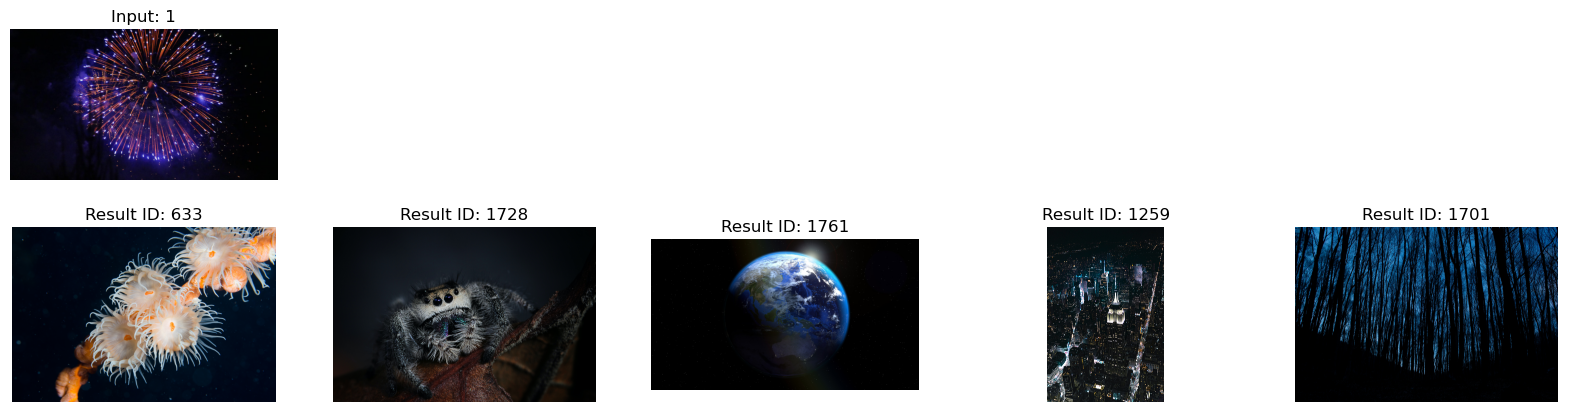

CPU times: total: 7.91 s
Wall time: 7.34 s


In [16]:
%%time
main_finding_similarities(1, "RGB", "euclidean_distance", 5)


# ___________________________________________________

In [17]:
# It could be (depending on the respective windows configuration)
# that the saved path is not the actual path on another windows system

# Change drive letter
old_drive_letter = 'E'
new_drive_letter = 'C'
df['Path'] = df['Path'].apply(lambda path: path.replace(f'{old_drive_letter}:', f'{new_drive_letter}:'))

df

In [18]:
# Required because removing entries with 'none' (during extraction) sometimes causes IDs to be missing
def correct_data():
    
    rgb_df, hsv_df, embedding_df, path_df, other_data_df = load_pickles()
    
    dataframes = [
        (rgb_df, 'RGB_Hist.pkl'),
        (hsv_df, 'HSV_Hist.pkl'),
        (embedding_df, 'Embedding.pkl'),
        (path_df, 'Path.pkl'),
        (other_data_df, 'Other_data.pkl')
    ]

    # Corrects mismatches from the mismatch-position until all mismatches are gone
    for df, filename in dataframes:
        while True:
            # IDs are index + 1 always
            expected_ids = df.index + 1

            mismatch_index = (df['ID'] != expected_ids).idxmax()

            # Break if no mismatch
            if df.loc[mismatch_index, 'ID'] == expected_ids[mismatch_index]:
                break

            # Reduce all IDs - 1 beginning from the mismatch
            df.loc[mismatch_index:, 'ID'] -= 1

        print(f"Corrected: {filename}")

        # Safe
        with open(filename, 'wb') as f:
            pickle.dump(df, f)
        print(f"Overwritten: {filename}\n")
        

In [19]:
%%time
correct_data()

Corrected: RGB_Hist.pkl
Overwritten: RGB_Hist.pkl

Corrected: HSV_Hist.pkl
Overwritten: HSV_Hist.pkl

Corrected: Embedding.pkl
Overwritten: Embedding.pkl

Corrected: Path.pkl
Overwritten: Path.pkl

Corrected: Other_data.pkl
Overwritten: Other_data.pkl

CPU times: total: 2min 37s
Wall time: 3min 2s


In [20]:
right_data = pd.read_pickle("Embedding.pkl")

In [21]:
right_data

,ID,Embedding
0,1,"[-0.107584916, -0.14763737, -0.17294389, -0.15..."
1,2,"[-0.19667886, 0.025466222, 0.28791898, 0.14967..."
2,3,"[0.05430079, -0.039901074, -0.20491275, -0.041..."
3,4,"[0.6793861, 0.24663632, -0.15594967, -0.164203..."
4,5,"[-0.13076307, -0.20843782, -0.22398338, -0.119..."
...,...,...
444663,444664,"[-0.21127301, -0.15229303, -0.15371165, 0.0619..."
444664,444665,"[-0.19530326, 0.072441205, -0.13462341, 0.1004..."
444665,444666,"[-0.13117982, 0.7346744, -0.23055367, 0.216335..."
444666,444667,"[-0.19311325, 0.0075957496, -0.14808089, -0.03..."
